# **Understanding natural language opinions**
## **with Topic Modeling and Summarization techniques.**

### Objetivos:

    Identificar las temáticas subyacentes al conjunto de opiniones.
    Facilitar la comprensión de las ideas y conceptos más sobresalientes en la Cognicion Colectiva de los usuarios.
    Automatizar este proceso que a un humano podría llevarle demasiado tiempo.    

## Preprocess

In [1]:
path_to_MyModule = '..'

import sys
sys.path.insert(0, path_to_MyModule) 

import pandas as pd
import matplotlib.pyplot as plt
from time import sleep

from MyModule.GeneralFunctions import *
from MyModule.SummarizationFunctions import *
from MyModule.SamplingFunctions import *
from MyModule.SemanticSimilarityFunctions import *
from MyModule.TopicModelingFunctinos import *

In [2]:
df = pd.read_excel('..\datos.xlsx')[['ID','texto','desafio']]

In [3]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

## Select the most representative documents of each desafio's cluster

1. Obtener un vector semántico para cada documento (utilizando SentenceTransformers)
2. Clusterizar los documentos en base a sus vectores (utilizando KMeans o HDBScan)
3. Evaluar la similitud coseno de cada documento con el centroide de su cluster
4. Devolver los documentos ordenados de mayor a menos similitud

Así, los documentos son presentados en el orden en el que más capturan el significado y las ideas expresadas por la mayoria.

In [6]:
from MyModule.SummarizationFunctions import MostRepresentativeDocs

pp_object = Preprocess(lemma=False)
mrd = MostRepresentativeDocs(cluster_algorithm='kmeans', min_cluster_size=5, min_samples=15)

In [7]:
all_res = {}
for des in df['desafio'].unique():
    data = df[df['desafio']==des]['texto'].values.tolist()
    result = mrd.get_representatives(data, 5, pp_object)
    all_res[des] = result

In [13]:
all_res['17'][1]

[('MEJORES HORARIOS, arrancar temprano y terminar mas temprano. Que las tutoriales de matematica sean optativas, cada uni hace las guias cuando mejor le convenga. Dejenos administras nuestro propio tiempo de estudio. Mas arboles en el medio del campus, somos muchos alumnos y en verano no hay suficientes sombras.',
  0.76712203),
 ('Más sillitas para sentarse en el campus, más espacios con sombra natural, horarios de la combi más puntuales (desde la estación victoria siempre algún retraso tiene y eso hace que lleguemos tarde a clases)',
  0.7414304),
 ('Más cursos de diseño ', 0.73938537),
 ('Ferias, speakers y que se invierta mas en los espacios de disenio que estan quedando un pco chicos.',
  0.72093),
 ('Una aplicación para sigedu y el campus virtual para no tener que entrar solo en la web, hablando todavia de sigedu siempre se traba y tiene mal conexión a la hora de la inscripción de las materias. Con la cuota que se paga creo que inversión no es un problema que falta en ese aspecto

## Word count plot

Plotear las palabras mas frecuentes para cada cluster

In [21]:
data = df[df['desafio']=='17']['texto'].values

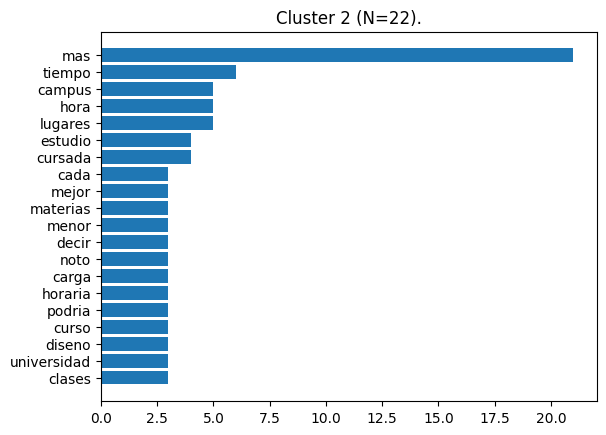

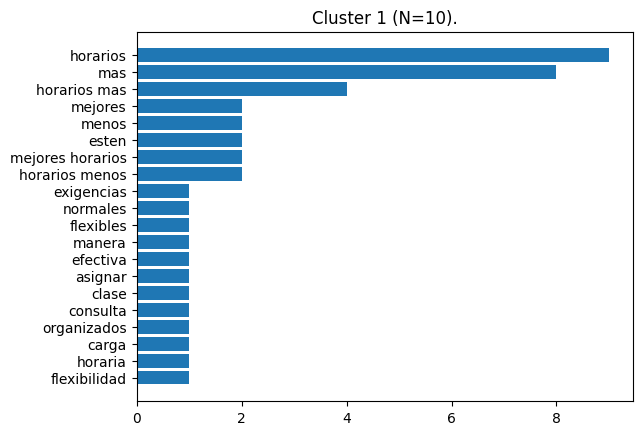

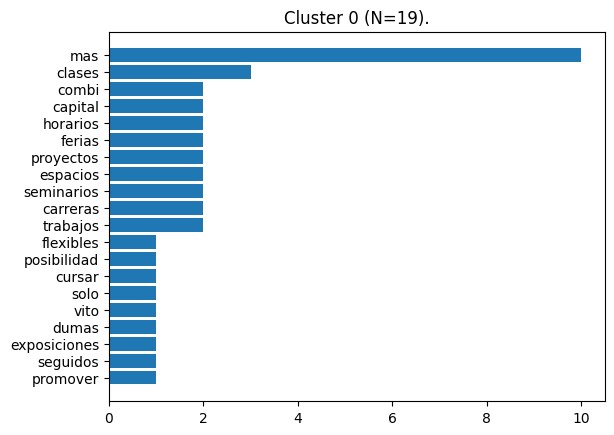

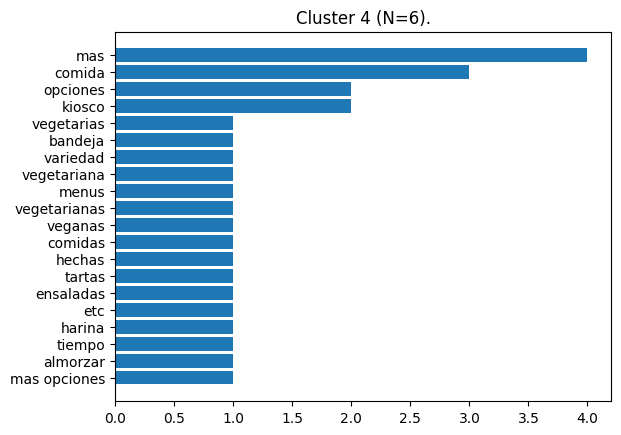

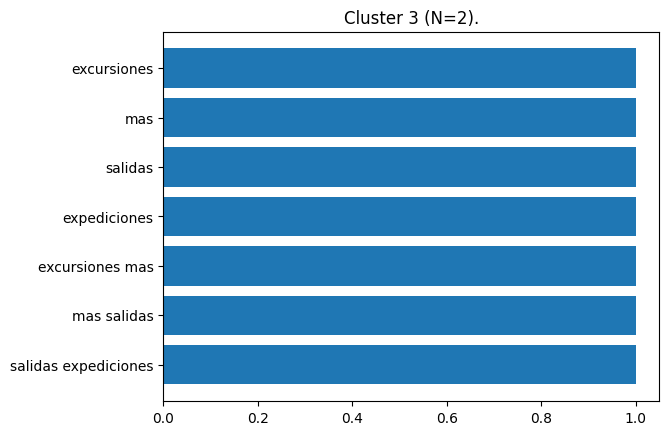

In [22]:
pp_object_transformers = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)
pp_object_word_count = Preprocess(lemma=False)

mrd.plot_word_counts(data, n_clusters=5, pp_object_transformers=pp_object_transformers, pp_object_word_count=pp_object_word_count)

## Finding optimum K
Eje X: numero de clusters

Eje Y: Sum of Squared Distance de cada punto con su centroide

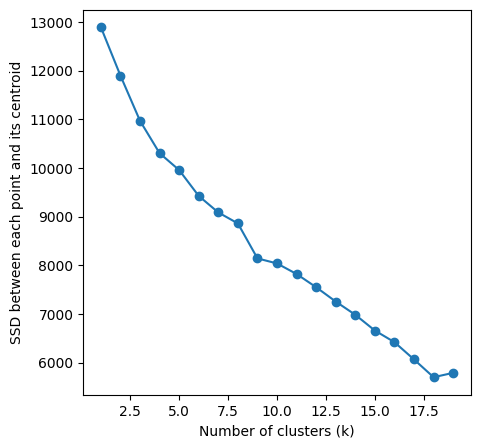

In [33]:
mrd.elbow_method(data, k_range=[1, 20], pp_object=pp_object)

## Clusters: Size and Shape

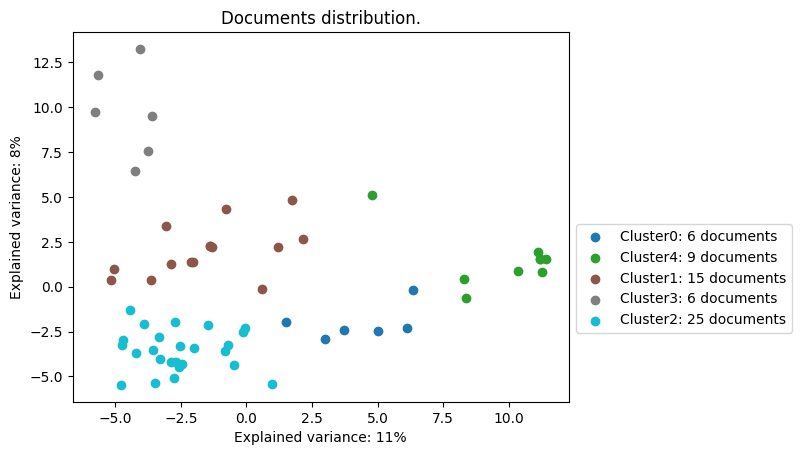

In [24]:
mrd.visualize_documents_kmeans(data, n_clusters=5, pp_object=pp_object)

# Combination: summarization for each topic's cluster

Apply T5 and BETO summarization to each cluster

In [28]:
# Models
beto = BETOSummary()
t5 = T5Summary()
embedding_model = MostRepresentativeDocs()

ckpt:
mrm8488/bert2bert_shared-spanish-finetuned-summarization


The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


ckpt:
josmunpen/mt5-small-spanish-summarization


In [29]:
desafio = '17'
data = df.query(f'desafio == "{desafio}"')['texto'].values
pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

In [30]:
labeled_docs = embedding_model.cluster_and_label_original_docs(data, 3, pp_object)

for key, values in labeled_docs.items():
    values = pp_object.preprocess(values)
    text = '.\n'.join(values)
    print(f'BERT, Cluster {key}:\n{beto.generate_summary(text)}\n\n')
    sleep(2)
    print(f'T5, Cluster {key}:\n{t5.generate_summary(text)}\n\n')

BERT, Cluster 1:
['La clase ping pong para la hora de la inmersa y la carga horaria de cursada es un plomazo', 'La clase que se paga creo que invertiron no es un problema que falta en ese periodo de tiempo']


T5, Cluster 1:
['la hora de cursada sea menor', 'la hora de cursada sea menor']


BERT, Cluster 0:
['Más flexibilidad a la hora de cambiar los horarios. Menos carga horaria. Mejor horarios, menos exigencia... mas horarios de combis', 'Más flexibilidad a la hora de cambiar los horarios. No se me ocurre otra cosa que me gustaria que agregaran. Pero una manera mas efectiva para asignar horarios']


T5, Cluster 0:
['mejores horarios, menos exigencias a la hora de cambiar los horarios', 'la hora de cambiar los horarios']


BERT, Cluster 2:
['La comida sin harina en el kiosco. mas menus de opciones vegetarianas y veganas, ensaladas, etc...', 'La comida sin harina en el kiosco. mas menus de opciones vegetarianas y veganas, ensaladas, etc.']


T5, Cluster 2:
['comida sin harina en el kio

# Sample representative docs

In [31]:
desafio = '17'

documents = df[df['desafio']==desafio]['texto'].values

pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

sr = SampleRepresentatives()
res = sr.get_sample(documents, pp_object=pp_object, n_clusters=5)

In [32]:
print(f'Desafio: {desafio}')
for key, value in res.items():
    print(f'\nCluster: {key}\n')
    for v in value[:3]:
        print(v)

Desafio: 17

Cluster: 1

Menos tareas extracurriculares ya que tenemos mucha carga horaria de cursada
mantas en la biblioteca.
Mejores horarios de cursada (menos baches).

Cluster: 3

Horarios mas normales
Horarios más estructurados, que sean o en la mañana o en la tarde, que estén juntos, y que estén distribuidos de forma uniforme a lo largo de la semana. 
más horarios de combis.

Cluster: 0

Comida sin harina en el kiosco 
Mesa de ping pong, canchita de futbol tenis y mesa teqball (es la mesa tipo ping pong para jugar con pelota de futbol)
más comidas hechas como tartas, ensaladas, etc

Cluster: 2

Estaria bueno que la experiencia 2023 tuviese clases magatrales mas pequeñas, de todas maneras me encanto como se dicto esta materia
Más sillitas para sentarse en el campus, más espacios con sombra natural, horarios de la combi más puntuales (desde la estación victoria siempre algún retraso tiene y eso hace que lleguemos tarde a clases)
La cursada sea menor, es decir, entiendo que el nivel